# Mini-Project 1 - Used Cars in the USA - SVM & LR Classification
#### By: David Wei, Sophia Wu, Dhruba Dey, Queena Wang

## Introduction
In this section we will continue using our used car dataset and be building out a classification model using Logistic Regression (LR) and Support Vector Machines (SVM). 

In [1]:
#importing libraries and reading in file
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') #ignoring warnings
import missingno as msno

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine.data import economics
from plotnine import ggplot, aes, geom_line

#general sklearn libraries
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
import ptitprince as pt
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as cross_validation
import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler #for scaling

#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score

For convenience and clarity, we have exported all of the data tidying and cleaning we have applied to our original dataset from our initial EDA workbook as an importable file. This will allow us to simply pick up on where we left off without cluttering our notebook with all prior code. For reference, please refer to the following [github link](https://github.com/chee154/ml-Py-used_cars/blob/main/Used_Car_Lab_1_DataVisualization.ipynb) where all work has been contained.

In [2]:
df_raw = pd.read_csv('data/finaldata.csv')
print('# of Records: '+str(len(df_raw)))
print('# of Columns: '+str(df_raw.shape[1]))

# of Records: 697989
# of Columns: 19


## Data Tidying

#### Addressing Empty Values
<b>NOTE</b>: First time running the logistic regression model returned an error: 
<br>
*ValueError: Input contains NaN, infinity or a value too large for dtype('float64').*
<br>
Therefore, we will fix this by once again removing any strangling NA records from our dataset.

In [3]:
df_cleaned = df_raw.copy()
df_cleaned = df_cleaned.dropna()
print(len(df_cleaned))
print('# of Records Removed: '+str(len(df_raw)-len(df_cleaned)))

697881
# of Records Removed: 108


#### Cleaning up final dataframe
After the initial EDA, we will make the appropriate adjustments to our dataset based on our findings. To begin, let's get look at the relationship between **'length'** and **'height'** due to it's high correlation.

In [4]:
df_test = df_cleaned.copy()
print(df_test.shape[1])

if df_test['length'].equals(df_test['height']) == True:
    print('they are the same... dropping one')
    df_test = df_test.drop(columns='height')
    print(df_test.shape[1])
else: 
    print('they are not the same')

19
they are the same... dropping one
18


## Data Transformations for Modeling

#### OneHotEncoding
Once the data has been imported and cleaned, we will work on transforming our dataset to be more useful for our classification models. To start we will first one-hot encode all of our categorical (object) datatypes as numbers.

In [5]:
def number_encode_features(df):
    result = df_cleaned.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object or result.dtypes[column]==np.bool:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    print('Columns converted: '+str(encoders))
    return result

Below shows a snap shot of what the final data looks like after categorical data has been encoded.
You can see the body type is in a numerical representation, instead of a string (object) type, before being encoded.
<br>
- Below shows a snap shot of what the final data looks like after categorical data has been encoded.
- You can see the body type is in a numerical representation, instead of a string (object) type, before being encoded.

In [6]:
encoded_data = number_encode_features(df_cleaned)
encoded_data

Columns converted: {'body_type': LabelEncoder(), 'frame_damaged': LabelEncoder(), 'has_accidents': LabelEncoder(), 'is_new': LabelEncoder()}


,Unnamed: 0,body_type,city_fuel_economy,daysonmarket,engine_displacement,frame_damaged,has_accidents,height,highway_fuel_economy,horsepower,is_new,length,maximum_seating,mileage,owner_count,price,seller_rating,width,year
0,38,6,27,55,1500,0,0,57.6,36,160,0,57.6,5.0,42394,1,14639.0,3.447761,73.0,2018
1,40,1,18,36,3500,0,0,55.1,24,311,0,55.1,4.0,62251,1,32000.0,2.800000,81.5,2018
2,41,5,18,27,3600,0,0,70.7,27,310,0,70.7,8.0,36410,1,23723.0,3.447761,78.6,2018
3,45,5,15,27,3600,0,1,69.9,22,281,0,69.9,8.0,36055,1,22422.0,3.447761,78.5,2017
4,47,5,18,24,3600,0,0,69.3,25,295,0,69.3,5.0,25745,1,29424.0,3.447761,84.8,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697984,3000026,5,26,32,1400,0,0,66.0,31,138,0,66.0,5.0,7444,1,17836.0,4.533333,69.9,2019
697985,3000028,5,26,17,2500,0,0,66.4,32,170,0,66.4,5.0,20160,1,20700.0,4.333333,80.0,2017
697986,3000031,6,26,17,2500,0,0,57.9,37,179,0,57.9,5.0,62138,1,17700.0,4.333333,72.0,2018
697987,3000034,4,18,89,3500,0,0,70.6,23,278,0,70.6,5.0,20009,1,40993.0,5.000000,75.2,2017


Referncing our transformed variable 'price_group' as an int to it's original string value for future analysis and interpretation

Now we are ready for some model building!

In [7]:
df_final = encoded_data.copy()
print('# of Records: '+str(len(df_final)))
print('# of Columns: '+str(df_final.shape[1]))
print()
print(df_final.dtypes)

# of Records: 697881
# of Columns: 19

Unnamed: 0                int64
body_type                 int64
city_fuel_economy         int64
daysonmarket              int64
engine_displacement       int64
frame_damaged             int64
has_accidents             int64
height                  float64
highway_fuel_economy      int64
horsepower                int64
is_new                    int64
length                  float64
maximum_seating         float64
mileage                   int64
owner_count               int64
price                   float64
seller_rating           float64
width                   float64
year                      int64
dtype: object


## Training and Testing Split
Once our dataset ready for modeling, we will move on to our next steps of splitting up our data. For our dataset, we will use a 70:30 split that roughly leaves our training set with 488k records and test set with the remainder (209k records). We will then apply a 3-fold Cross Validation with a seed of 42 because it (42) is the answer to the ultimate question of life, the universe, and everything.
<br><br>
Our resposne variable will be price, more specifically the price group ('price_group') a car falls in.

In [8]:
if 'has_accidents' in df_final:
    y = df_final['has_accidents'].values # get the labels we want
    del df_final['has_accidents'] # get rid of the class label
    X = df_final.values # use everything else to predict!
print(y)
print(X)

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=42, test_size= 0.3)     
print(cv_object)

[0 0 0 ... 0 0 0]
[[3.80000000e+01 6.00000000e+00 2.70000000e+01 ... 3.44776119e+00
  7.30000000e+01 2.01800000e+03]
 [4.00000000e+01 1.00000000e+00 1.80000000e+01 ... 2.80000000e+00
  8.15000000e+01 2.01800000e+03]
 [4.10000000e+01 5.00000000e+00 1.80000000e+01 ... 3.44776119e+00
  7.86000000e+01 2.01800000e+03]
 ...
 [3.00003100e+06 6.00000000e+00 2.60000000e+01 ... 4.33333333e+00
  7.20000000e+01 2.01800000e+03]
 [3.00003400e+06 4.00000000e+00 1.80000000e+01 ... 5.00000000e+00
  7.52000000e+01 2.01700000e+03]
 [3.00003900e+06 5.00000000e+00 2.60000000e+01 ... 4.33333333e+00
  7.24000000e+01 2.01700000e+03]]
ShuffleSplit(n_splits=3, random_state=42, test_size=0.3, train_size=None)


## Logistic Regression

In [9]:
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) 

In [10]:
iter_num=0

for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
accuracy 0.8787428653308815
confusion matrix
 [[183843    227]
 [ 25160    135]]
====Iteration 1  ====
accuracy 0.8775153440164306
confusion matrix
 [[183586    220]
 [ 25424    135]]
====Iteration 2  ====
accuracy 0.8774723568886872
confusion matrix
 [[183593    220]
 [ 25433    119]]


In [11]:
print('Count of Training Set: '+str(len(train_indices)))
print('Count of Test Set: '+ str(len(test_indices)))

Count of Training Set: 488516
Count of Test Set: 209365


In [12]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None,solver='liblinear') # get object
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)

interactive(children=(FloatSlider(value=2.451, description='cost', max=5.0, min=0.001, step=0.05), Output()), …

<function __main__.lr_explor(cost)>

### LR - Analysis & Intepretations

**Weights *before* normalization:**
<br>
We can see that even before we normalized our dataset the **'mileage'** and **'frame_damaged'** attribute showns an extremely strong weight in regards to the price (and group) of a vehicle. Additionally, we can see that **'is_new'** has a particularly strong negative weight in regards to price, this can be interpreted that this variable less of an effect on pricing, which makes sense since prior analysis (lab 1) showed us that 99% of our data is used cars. 

In [13]:
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_final.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

Unnamed: 0 has weight of -1.396861357038937e-07
body_type has weight of -2.5981275078374023e-06
city_fuel_economy has weight of -1.4324703284880963e-05
daysonmarket has weight of -1.3306102423230866e-05
engine_displacement has weight of 7.331260439858422e-05
frame_damaged has weight of 7.010475284456488e-08
height has weight of -2.4595081026030185e-05
highway_fuel_economy has weight of -1.7849726010989423e-05
horsepower has weight of 9.72839505417779e-06
is_new has weight of -3.452853514308244e-09
length has weight of -2.4595081026030185e-05
maximum_seating has weight of -1.9311842156275915e-06
mileage has weight of 8.152321924486405e-06
owner_count has weight of 3.913495846540086e-07
price has weight of -3.0232903497953158e-05
seller_rating has weight of -2.0346686000695937e-06
width has weight of -2.9499706770011897e-05
year has weight of -0.0008687338714986058


**Weights *after* normalization:**
<br>
Once the weights have been normalized as shown below 

In [14]:
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

accuracy: 0.8776443053996609
[[183411    402]
 [ 25215    337]]


In [15]:
# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_final.columns) # combine attributes
zip_vars = sorted(zip_vars) 

for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

price has weight of -0.3969057641438789
Unnamed: 0 has weight of -0.1207809896301881
year has weight of -0.09241931425652257
city_fuel_economy has weight of -0.0804046119305599
seller_rating has weight of -0.062317310781509656
width has weight of -0.05750555194346123
is_new has weight of -0.03996629113807589
engine_displacement has weight of -0.03521905763730204
daysonmarket has weight of 0.010180291675512687
body_type has weight of 0.011825186108447633
height has weight of 0.013762135863874935
length has weight of 0.013762135863874935
maximum_seating has weight of 0.019853486814970085
frame_damaged has weight of 0.08492643200182318
owner_count has weight of 0.10797531437321116
highway_fuel_economy has weight of 0.1326227309819771
horsepower has weight of 0.16205448375943524
mileage has weight of 0.21582009381833273


In [16]:
print(lr_clf.coef_.T)

[[-0.12078099]
 [ 0.01182519]
 [-0.08040461]
 [ 0.01018029]
 [-0.03521906]
 [ 0.08492643]
 [ 0.01376214]
 [ 0.13262273]
 [ 0.16205448]
 [-0.03996629]
 [ 0.01376214]
 [ 0.01985349]
 [ 0.21582009]
 [ 0.10797531]
 [-0.39690576]
 [-0.06231731]
 [-0.05750555]
 [-0.09241931]]


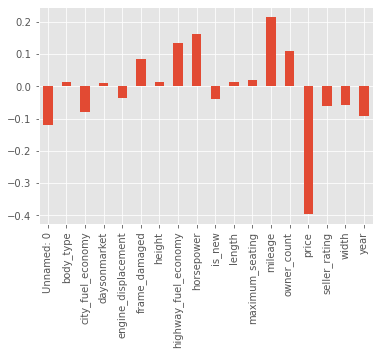

In [17]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df_final.columns)
weights.plot(kind='bar')
plt.show()

In [18]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

## Dimensionality Reduction for SVM

## Support Vector Machines

In [18]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [ ]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC


# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

In [19]:
######sophia SVM

In [43]:
# lets investigate SVMs on the data and play with the parameters and kernels
#from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


# import some data to play with
X, y = make_classification(
    n_features=18, n_informative=3, n_redundant=0, n_classes=2,
    n_clusters_per_class=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=590000)


svm_clf = svm.LinearSVC()
svm_clf.fit(X_train, y_train)
y_hat = svm_clf.predict(X_test)
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.92
[[12  0]
 [ 2 11]]


In [ ]:
#####sophia SVM

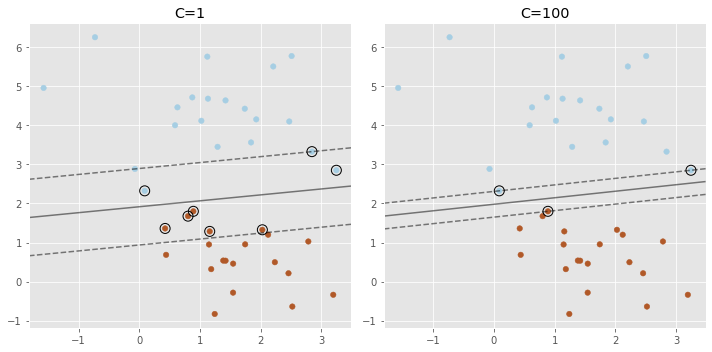

In [54]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=40, centers=2, random_state=0)

plt.figure(figsize=(10, 5))
for i, C in enumerate([1, 100]):
    # "hinge" is the standard SVM loss
    clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    # The support vectors are the samples that lie within the margin
    # boundaries, whose size is conventionally constrained to 1
    support_vector_indices = np.where(
        np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.title("C=" + str(C))
plt.tight_layout()
plt.show()

In [41]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

AttributeError: 'LinearSVC' object has no attribute 'support_vectors_'

### LR vs SVM